In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
sns.set_context('paper', font_scale=1.75)

# Preparation data

In [18]:
labs = pd.read_csv('data/eicu/labs_first_day.csv', index_col = [0, 1], header = [0, 1])
outcomes = pd.read_csv('data/eicu/outcomes_first_day.csv', index_col = 0)
labs.columns = labs.columns.droplevel() 

In [ ]:
# For paper's tables
labs = pd.read_csv('data/eicu/labs_first_day_subselection.csv', index_col = [0, 1])
outcomes = pd.read_csv('data/eicu/outcomes_first_day_subselection.csv', index_col = 0)

### Analysis

In [19]:
labs

Lab               -basos  -eos  -lymphs  -monos  -polys  ALT (SGPT)  \
Patient Time                                                          
141194  0.215278     NaN   NaN      NaN     NaN     NaN         NaN   
        0.216667     0.0   0.0      1.0     1.0    98.0        20.0   
        0.461806     NaN   NaN      NaN     NaN     NaN         NaN   
        0.463194     NaN   NaN      NaN     NaN     NaN         NaN   
        0.529167     NaN   NaN      NaN     NaN     NaN         NaN   
...                  ...   ...      ...     ...     ...         ...   
3353254 0.467361     NaN   NaN      NaN     NaN     NaN         NaN   
        0.677778     NaN   NaN      NaN     NaN     NaN         NaN   
        0.845833     0.0   0.0      7.0     6.0     NaN         NaN   
3353263 0.459722     NaN   NaN      NaN     NaN     NaN         NaN   
        0.770139     NaN   NaN      NaN     NaN     NaN         NaN   

Lab               AST (SGOT)   BUN  Base Deficit  Base Excess  ...  pH  paCO2  \
Patient Time                                                   ...              
141194  0.215278         NaN   NaN           NaN          NaN  ... NaN    NaN   
        0.216667        24.0  31.0           NaN          NaN  ... NaN    NaN   
        0.461806         NaN   NaN           NaN          NaN  ... NaN    NaN   
        0.463194         NaN   NaN           NaN          NaN  ... NaN    NaN   
        0.529167         NaN  30.0           NaN          NaN  ... NaN    NaN   
...                      ...   ...           ...          ...  ...  ..    ...   
3353254 0.467361         NaN   NaN           NaN          NaN  ... NaN    NaN   
        0.677778         NaN   NaN           NaN          NaN  ... NaN    NaN   
        0.845833         NaN  45.0           NaN          NaN  ... NaN    NaN   
3353263 0.459722         NaN   NaN           NaN          NaN  ... NaN    NaN   
        0.770139         NaN   NaN           NaN          NaN  ... NaN    NaN   

Lab               paO2  phosphate  platelets x 1000  potassium  sodium  \
Patient Time                                                             
141194  0.215278   NaN        NaN               NaN        NaN     NaN   
        0.216667   NaN        NaN             233.0        4.0   135.0   
        0.461806   NaN        NaN               NaN        NaN     NaN   
        0.463194   NaN        NaN               NaN        NaN     NaN   
        0.529167   NaN        NaN               NaN        3.7   134.0   
...                ...        ...               ...        ...     ...   
3353254 0.467361   NaN        NaN               NaN        NaN     NaN   
        0.677778   NaN        NaN               NaN        NaN     NaN   
        0.845833   NaN        3.7             183.0        5.7   141.0   
3353263 0.459722   NaN        NaN               NaN        NaN     NaN   
        0.770139   NaN        NaN               NaN        NaN     NaN   

Lab               total bilirubin  total protein  troponin - I  
Patient Time                                                    
141194  0.215278              NaN            NaN           NaN  
        0.216667              0.4            6.9           NaN  
        0.461806              NaN            NaN           NaN  
        0.463194              NaN            NaN           NaN  
        0.529167              NaN            NaN           NaN  
...                           ...            ...           ...  
3353254 0.467361              NaN            NaN           NaN  
        0.677778              NaN            NaN           NaN  
        0.845833              NaN            NaN           NaN  
3353263 0.459722              NaN            NaN           NaN  
        0.770139              NaN            NaN           NaN  

[881227 rows x 55 columns]

<AxesSubplot:ylabel='Lab'>

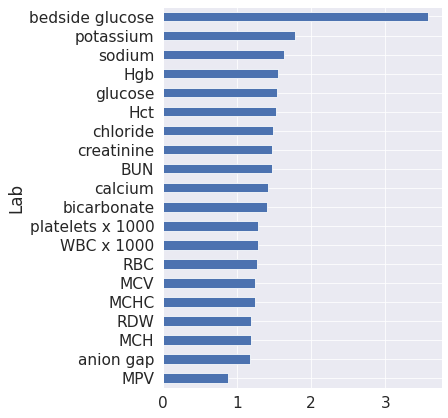

In [20]:
labs.groupby('Patient').count().mean().sort_values()[-20:].plot.barh(figsize = (5,7))

### How many different labs in this period ?

In [21]:
number_events = ((~labs.isna()).sum(axis = 1) > 0).groupby('Patient').sum()
number_events.describe()

count    121839.000000
mean          7.232717
std           6.683427
min           1.000000
25%           3.000000
50%           5.000000
75%           9.000000
max          98.000000
dtype: float64

### In hospial mortality

In [27]:
print("In hospital mortality: {:.2f} %".format(100 * outcomes.Death.mean()))
outcomes[['teachingstatus', 'Death']].groupby('teachingstatus').mean()

In hospital mortality: 7.80 %


,Death
teachingstatus,
f,0.075831
t,0.083922


# Analysis per admission day

In [37]:
# Prepreocess ethnicity
ethnicity = outcomes.ethnicity.copy().replace({"Caucasian": 'White', 'African American': 'Black'})
ethnicity[(ethnicity != "Asian") & (ethnicity != "Hispanic") & (ethnicity != "Black") & (ethnicity != "White")] = 'Other'

outcomes.ethnicity = ethnicity

In [50]:
teaching = outcomes[outcomes.teachingstatus == 't']
nonteaching = outcomes[outcomes.teachingstatus == 'f']

labs_t = labs.loc[teaching.index]
labs_f = labs.loc[nonteaching.index]

In [44]:
los_mean_t = teaching['LOS'].mean()
los_std_t = teaching['LOS'].std()
los_mean_f = nonteaching['LOS'].mean()
los_std_f = nonteaching['LOS'].std()
los = pd.DataFrame({'Mean': [outcomes['LOS'].mean(), los_mean_f, los_mean_t],
                    'Std': [outcomes['LOS'].std(), los_std_f, los_std_t]}, index = ['Population', 'Non Teaching', 'Teaching']).T

death_t = (~teaching['Death'].isna()).mean()
death_f = (~nonteaching['Death'].isna()).mean()
death = pd.DataFrame({'':[(~outcomes['Death'].isna()).mean(), death_f, death_t]}, index = ['Population', 'Non Teaching', 'Teaching']).T*100

ethnicity_t = ethnicity.loc[teaching.index].value_counts() / len(ethnicity.loc[teaching.index])
ethnicity_f = ethnicity.loc[nonteaching.index].value_counts() / len(ethnicity.loc[nonteaching.index])
ethnicity = pd.concat({"Population": ethnicity.value_counts() / len(ethnicity), "Non Teaching": ethnicity_f, "Teaching": ethnicity_t}, 1)*100

gender_t = teaching['gender'].value_counts() / len(teaching)
gender_f = nonteaching['gender'].value_counts() / len(nonteaching)
gender = pd.concat({"Population": outcomes['gender'].value_counts() / len(outcomes), "Non Teaching": gender_f, "Teaching": gender_t}, 1)*100

/tmp/ipykernel_28901/1711411901.py:14: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  ethnicity = pd.concat({"Population": ethnicity.value_counts() / len(ethnicity), "Non Teaching": ethnicity_f, "Teaching": ethnicity_t}, 1)*100
/tmp/ipykernel_28901/1711411901.py:18: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  gender = pd.concat({"Population": outcomes['gender'].value_counts() / len(outcomes), "Non Teaching": gender_f, "Teaching": gender_t}, 1)*100


In [45]:
analysis = pd.concat({'LOS': los,
           'Death': death,
           'Gender': gender,
           'Ethnicity': ethnicity})
print(analysis.to_latex(float_format="{:0.2f}".format))
analysis

\begin{tabular}{llrrr}
\toprule
          &       &  Population &  Non Teaching &  Teaching \\
\midrule
LOS & Mean &        7.21 &          8.12 &      6.87 \\
          & Std &        9.47 &          9.02 &      9.61 \\
Death &       &      100.00 &        100.00 &    100.00 \\
Gender & Male &       53.96 &         55.06 &     53.55 \\
          & Female &       46.02 &         44.92 &     46.43 \\
          & Unknown &        0.01 &          0.02 &      0.01 \\
          & Other &        0.00 &          0.01 &      0.00 \\
Ethnicity & White &       77.14 &         76.85 &     77.24 \\
          & Black &       10.72 &         14.45 &      9.34 \\
          & Other &        6.59 &          4.85 &      7.24 \\
          & Hispanic &        3.83 &          2.65 &      4.27 \\
          & Asian &        1.72 &          1.20 &      1.92 \\
\bottomrule
\end{tabular}



Population  Non Teaching    Teaching
LOS       Mean        7.208571      8.124937    6.868419
          Std         9.466725      9.017911    9.605828
Death               100.000000    100.000000  100.000000
Gender    Male       53.957271     55.055635   53.549563
          Female     46.019747     44.917078   46.429054
          Unknown     0.009028      0.015159    0.006752
          Other       0.004925      0.012127    0.002251
Ethnicity White      77.136221     76.851711   77.241829
          Black      10.720705     14.449868    9.336454
          Other       6.591485      4.847952    7.238678
          Hispanic    3.828823      2.646818    4.267579
          Asian       1.722765      1.203650    1.915459

In [46]:
count_mean = labs.groupby('Patient').count().mean()
count_std = labs.groupby('Patient').count().std()
value_mean = labs.groupby('Patient').mean().mean()
value_std = labs.groupby('Patient').mean().std()

In [47]:
tests = pd.DataFrame({('Number Test', 'Mean'): count_mean,
           ('Number Test', 'Std'):count_std, 
           ('Value', 'Mean'): value_mean, 
           ('Value', 'Std'): value_std})
print(tests.to_latex(float_format="{:0.2f}".format))
tests

\begin{tabular}{lrrrr}
\toprule
{} & \multicolumn{2}{l}{Number Test} & \multicolumn{2}{l}{Value} \\
{} &        Mean &  Std &    Mean &      Std \\
Lab               &             &      &         &          \\
\midrule
-basos            &        0.60 & 0.74 &    0.22 &     0.39 \\
-eos              &        0.61 & 0.75 &    0.97 &     1.73 \\
-lymphs           &        0.67 & 0.77 &   12.97 &    10.22 \\
-monos            &        0.67 & 0.77 &    7.23 &     3.97 \\
-polys            &        0.59 & 0.75 &   76.45 &    14.36 \\
ALT (SGPT)        &        0.50 & 0.69 &   94.78 &   390.28 \\
AST (SGOT)        &        0.51 & 0.69 &  147.82 &   728.01 \\
BUN               &        1.47 & 1.11 &   24.71 &    20.20 \\
Base Deficit      &        0.15 & 0.73 &    4.76 &     4.07 \\
Base Excess       &        0.58 & 1.35 &   -1.11 &     6.09 \\
CPK               &        0.28 & 0.75 & 1352.00 & 11663.37 \\
CPK-MB            &        0.21 & 0.67 &   32.31 &    84.24 \\
Carboxyhemoglobin &     

Number Test                  Value              
                         Mean       Std         Mean           Std
Lab                                                               
-basos               0.596911  0.743005     0.222433      0.386946
-eos                 0.611643  0.746321     0.967291      1.725807
-lymphs              0.672305  0.771112    12.970301     10.220513
-monos               0.668316  0.769436     7.226733      3.969767
-polys               0.594251  0.752041    76.454017     14.362839
ALT (SGPT)           0.499996  0.685541    94.778535    390.284612
AST (SGOT)           0.507136  0.690146   147.822563    728.011423
BUN                  1.468036  1.106996    24.710770     20.202988
Base Deficit         0.150354  0.726050     4.763197      4.069675
Base Excess          0.578764  1.353225    -1.108852      6.091558
CPK                  0.281470  0.752106  1352.001496  11663.369267
CPK-MB               0.208529  0.672383    32.309401     84.236740
Carboxyhemoglobin    0.178457  0.768811     1.016270      0.761182
FiO2                 0.772987  1.412634    51.020415    176.230577
HCO3                 0.742907  1.511201    23.314000      6.056420
Hct                  1.522895  1.226241    33.663182      6.373521
Hgb                  1.554404  1.326409    11.154813      2.197390
MCH                  1.185294  0.911013    29.861309      2.585039
MCHC                 1.244363  0.897575    33.104523      1.404494
MCV                  1.245102  0.898570    90.205419      6.772861
MPV                  0.874269  0.932508     9.736101      1.321000
Methemoglobin        0.175239  0.777635     0.563658      0.478818
O2 Sat (%)           0.628108  1.380053    95.642877      5.666198
PEEP                 0.240974  0.825860     7.193278     20.978999
PT                   0.489310  0.806242    17.267992      8.554666
PT - INR             0.506898  0.821520     1.522534      0.883521
PTT                  0.390852  0.820502    39.803437     20.649843
RBC                  1.273098  0.885132     3.751408      0.746083
RDW                  1.185466  0.913439    15.028965      2.308867
TV                   0.190555  0.728691   668.255382  17162.931579
Temperature          0.215744  0.859893    47.577043     23.188555
Total CO2            0.292837  1.033003    26.084424      9.423430
WBC x 1000           1.280542  0.880655    11.981416      8.441228
albumin              0.553813  0.735441     2.922249      0.661967
alkaline phos.       0.492470  0.683041    95.896140     90.104703
anion gap            1.182101  1.161165    10.736099      4.222483
bedside glucose      3.576638  5.172049   147.587492     50.189322
bicarbonate          1.398903  1.158560    24.041653      4.588306
calcium              1.424462  1.108720     8.283671      0.754318
chloride             1.492429  1.170669   104.781245      6.284654
creatinine           1.477819  1.109176     1.434854      1.543529
glucose              1.542076  1.323054   141.642041     59.247387
ionized calcium      0.240834  0.876752     3.851123      2.410128
lactate              0.481989  1.091025     2.272700      2.132216
magnesium            0.814821  0.977042     1.960714      0.410180
pH                   0.780079  1.562232     7.380488      3.615774
paCO2                0.780858  1.559205    41.617311     11.720525
paO2                 0.788631  1.562951   126.020147     67.894612
phosphate            0.490910  0.846360     3.516396      1.434151
platelets x 1000     1.282488  0.908038   200.957764     91.528709
potassium            1.777009  1.532605     4.084839      0.569352
sodium               1.637489  1.432982   138.437958      4.931127
total bilirubin      0.492765  0.683620     1.136822      2.232392
total protein        0.500521  0.684918     5.928531      0.925449
troponin - I         0.418134  0.934321     7.289885     27.735456

In [52]:
count_mean_f = labs_f.groupby('Patient').count().mean()
count_std_f = labs_f.groupby('Patient').count().std()
value_mean_f = labs_f.groupby('Patient').mean().mean()
value_std_f = labs_f.groupby('Patient').mean().std()

count_mean_t = labs_t.groupby('Patient').count().mean()
count_std_t = labs_t.groupby('Patient').count().std()
value_mean_t = labs_t.groupby('Patient').mean().mean()
value_std_t = labs_t.groupby('Patient').mean().std()

In [54]:
import scipy.stats

In [55]:
tests = pd.DataFrame({('Number Test', 'Teaching', 'Mean'): count_mean_t, 
            ('Number Test', 'Non Teaching', 'Mean'): count_mean_f, 
            ('Number Test', 'Test', 'P Value'): [scipy.stats.ttest_ind(labs_f[i].groupby('Patient').count().dropna(), labs_t[i].groupby('Patient').count().dropna())[1] for i in labs_t.columns],
           ('Value', 'Teaching', 'Mean'): value_mean_t, 
           ('Value', 'Non Teaching', 'Mean'): value_mean_f,
           ('Value', 'Test', 'P Value'): [scipy.stats.ttest_ind(labs_f[i].groupby('Patient').mean().dropna(), labs_t[i].groupby('Patient').mean().dropna())[1] for i in labs_t.columns],
           
          })
print(tests.loc[labs.groupby('Patient').count().mean().sort_values().index].to_latex(float_format="{:0.3f}".format))
tests

\begin{tabular}{lrrrrrr}
\toprule
{} & \multicolumn{3}{l}{Number Test} & \multicolumn{3}{l}{Value} \\
{} &    Teaching & Non Teaching &    Test & Teaching & Non Teaching &    Test \\
{} &        Mean &         Mean & P Value &     Mean &         Mean & P Value \\
Lab               &             &              &         &          &              &         \\
\midrule
Base Deficit      &       0.122 &        0.161 &   0.000 &    4.140 &        4.898 &   0.000 \\
Methemoglobin     &       0.186 &        0.171 &   0.004 &    0.571 &        0.561 &   0.394 \\
Carboxyhemoglobin &       0.168 &        0.182 &   0.005 &    1.070 &        1.000 &   0.000 \\
TV                &       0.158 &        0.203 &   0.000 &  482.795 &      714.776 &   0.561 \\
CPK-MB            &       0.253 &        0.192 &   0.000 &   35.397 &       31.039 &   0.006 \\
Temperature       &       0.229 &        0.211 &   0.001 &   40.721 &       49.913 &   0.000 \\
ionized calcium   &       0.510 &        0.141 &   0.00

Number Test                                    Value  \
                     Teaching Non Teaching           Test     Teaching   
                         Mean         Mean        P Value         Mean   
Lab                                                                      
-basos               0.598824     0.596201   5.840160e-01     0.201617   
-eos                 0.619198     0.608839   3.134422e-02     0.894241   
-lymphs              0.687112     0.666809   4.435624e-05    12.690109   
-monos               0.684929     0.662150   4.398194e-06     7.392678   
-polys               0.641997     0.576528   1.427467e-41    77.600797   
ALT (SGPT)           0.488191     0.504378   2.500989e-04   114.168160   
AST (SGOT)           0.492830     0.512447   1.039851e-05   179.524713   
BUN                  1.631356     1.407412  5.982003e-217    24.271807   
Base Deficit         0.121608     0.161025   3.730579e-17     4.140428   
Base Excess          0.926295     0.449761   0.000000e+00    -1.642626   
CPK                  0.293242     0.277100   8.724089e-04  1856.295321   
CPK-MB               0.253009     0.192019   5.494318e-45    35.397435   
Carboxyhemoglobin    0.168329     0.182216   5.086682e-03     1.069912   
FiO2                 0.951035     0.706897  1.000459e-158    45.756607   
HCO3                 0.998514     0.648026  7.644098e-285    23.139582   
Hct                  1.775308     1.429200   0.000000e+00    33.405365   
Hgb                  1.862505     1.440038   0.000000e+00    11.085021   
MCH                  1.405239     1.103651   0.000000e+00    29.772889   
MCHC                 1.476397     1.158234   0.000000e+00    33.096555   
MCV                  1.476518     1.159201   0.000000e+00    90.005746   
MPV                  1.216415     0.747265   0.000000e+00     9.978788   
Methemoglobin        0.185823     0.171311   3.799138e-03     0.570514   
O2 Sat (%)           0.775218     0.573501  5.220276e-114    95.219415   
PEEP                 0.179729     0.263708   4.347178e-56    12.683584   
PT                   0.647394     0.430629   0.000000e+00    16.582201   
PT - INR             0.689173     0.439239   0.000000e+00     1.455933   
PTT                  0.522815     0.341868  1.288758e-257    38.228660   
RBC                  1.468999     1.200380   0.000000e+00     3.728754   
RDW                  1.391111     1.109132   0.000000e+00    14.997665   
TV                   0.157960     0.202654   1.830220e-21   482.795140   
Temperature          0.228966     0.210836   1.074616e-03    40.720528   
Total CO2            0.490434     0.219490   0.000000e+00    25.025601   
WBC x 1000           1.473517     1.208911   0.000000e+00    12.057113   
albumin              0.526150     0.564081   1.242245e-15     2.981408   
alkaline phos.       0.459570     0.504682   1.241271e-24    97.680126   
anion gap            1.417761     1.094625   0.000000e+00    11.039338   
bedside glucose      4.455295     3.250484  2.394572e-287   141.398972   
bicarbonate          1.650335     1.305573   0.000000e+00    23.609831   
calcium              1.515265     1.390756   5.070012e-68     8.322532   
chloride             1.691841     1.418407  6.929568e-289   104.694150   
creatinine           1.639996     1.417620  4.164413e-213     1.455784   
glucose              1.770276     1.457369  3.597803e-296   139.612099   
ionized calcium      0.510051     0.140902   0.000000e+00     4.377362   
lactate              0.704211     0.399500   0.000000e+00     2.238058   
magnesium            0.966255     0.758609  2.554296e-239     1.949938   
pH                   1.105054     0.659449   0.000000e+00     7.360248   
paCO2                1.103599     0.661058   0.000000e+00    41.586286   
paO2                 1.100233     0.672965   0.000000e+00   132.375940   
phosphate            0.718552     0.406410   0.000000e+00     3.548920   
platelets x 1000     1.492587     1.204499   0.000000e+00   198.935914   
potassium            2

In [63]:
ordered_test = labs.groupby('Patient').count().sum(1).to_frame(name = 'Total tests ordered').join(
    (outcomes.teachingstatus).rename("Institution").replace({'t': "Teaching", 'f': "Non teaching"})
    ).join(outcomes.Death.rename("Outcome").replace({True: "Death", False: "Discharge"}))

(20.0, 100.0)

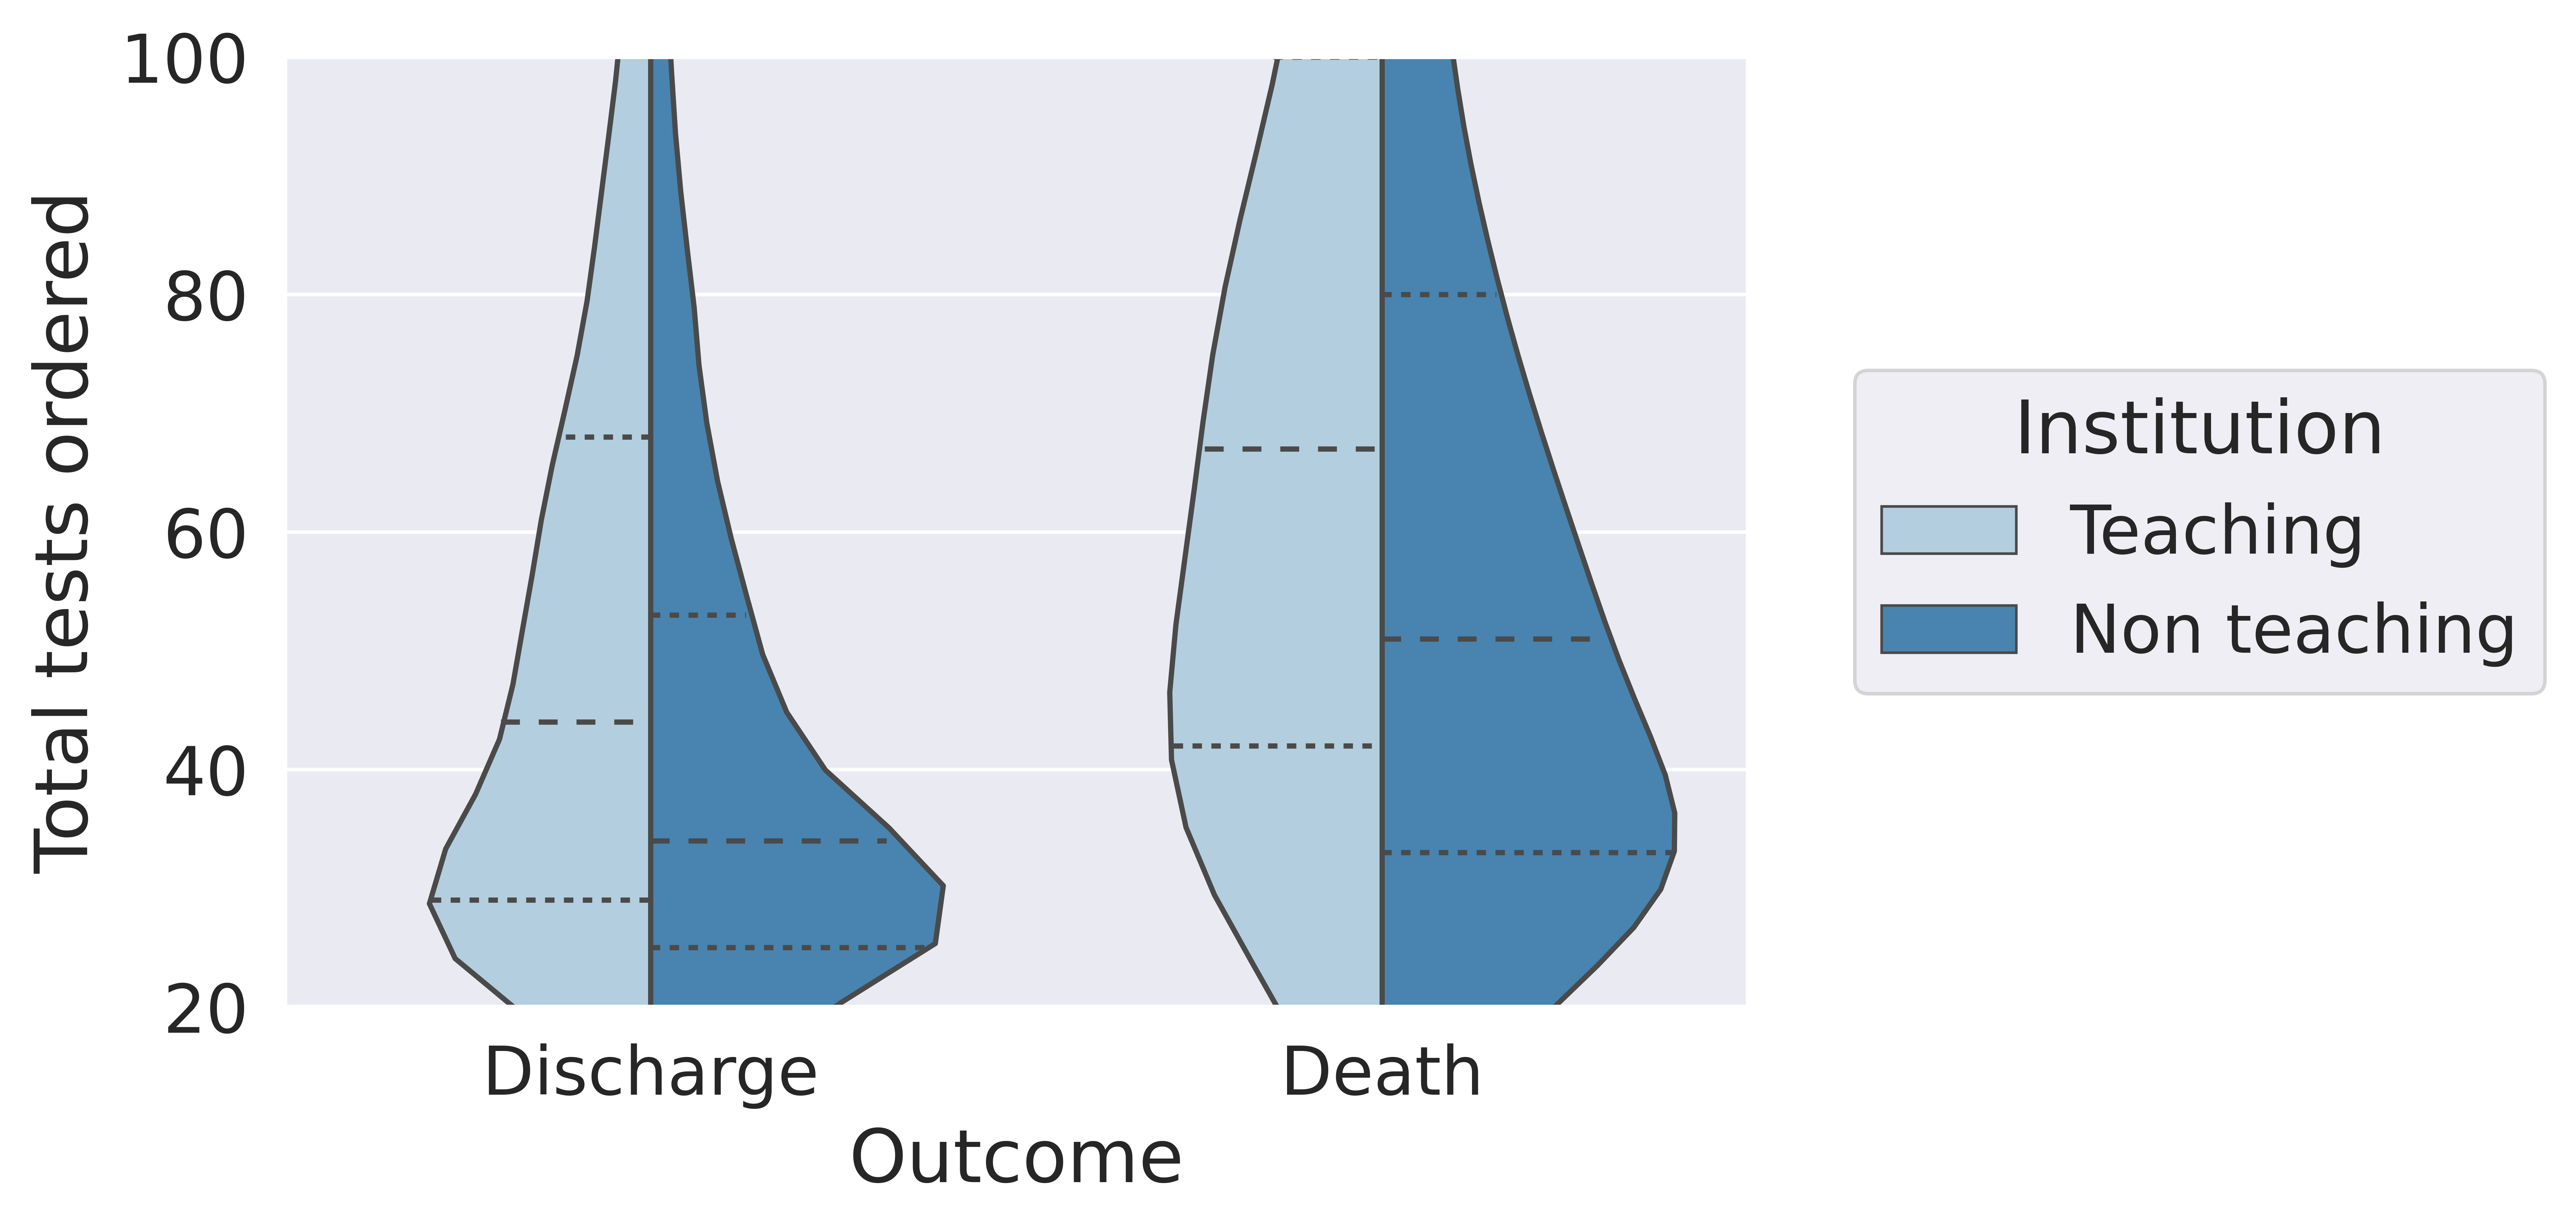

In [64]:
plt.figure(dpi = 1000)
ax = sns.violinplot(x = "Outcome", y = "Total tests ordered", hue = 'Institution', data = ordered_test, split = True, inner = 'quartile', palette = "Blues", cut = 0, fig_size = (10,5))
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), title = 'Institution')
plt.ylim(20, 100)

# Analyze available labs

Subselect features to use.

In [65]:
from FeatureAnalysis.analysis.eclat import eclat
from FeatureAnalysis.analysis.rendering import buildGraph

In [66]:
missing_data = labs.groupby('Patient').count()
missing_data[missing_data <= 0] = np.nan
missing_data[0 < missing_data] = 1

In [76]:
features = eclat(missing_data, minCount = 80000)
print(features)
buildGraph(features, mainBranch = True).render('examples/small')

  0%|          | 0/55 [00:00<?, ?it/s]

In [ ]:
def next_feature(node):
    if len(node.children) == 0:
        return [node.name]
    return [node.name] + next_feature(node.children[0])

In [ ]:
# Remove patients with no values
selection = labs[next_feature(features.children[0])][next_feature(features.children[0])]
selection = (selection.groupby('Patient').count() == 0).sum(1) == 0
selection = selection.index[selection]

In [ ]:
labs[labs.index.get_level_values('Patient').isin(selection)][next_feature(features.children[0])]

Lab                BUN   Hct   Hgb  MCHC   MCV   RBC  WBC x 1000  chloride  \
Patient Time                                                                 
141194  0.215278   NaN   NaN   NaN   NaN   NaN   NaN         NaN       NaN   
        0.216667  31.0  27.4   8.9  32.5  79.9  3.43        14.1     105.0   
        0.461806   NaN   NaN   NaN   NaN   NaN   NaN         NaN       NaN   
        0.463194   NaN   NaN   NaN   NaN   NaN   NaN         NaN       NaN   
        0.529167  30.0   NaN   NaN   NaN   NaN   NaN         NaN     108.0   
...                ...   ...   ...   ...   ...   ...         ...       ...   
3353254 0.146528   NaN   NaN   NaN   NaN   NaN   NaN         NaN       NaN   
        0.273611   NaN  32.0  10.5   NaN   NaN   NaN         NaN       NaN   
        0.467361   NaN  29.0   9.2   NaN   NaN   NaN         NaN       NaN   
        0.677778   NaN  23.0   7.3   NaN   NaN   NaN         NaN       NaN   
        0.845833  45.0  25.0   8.2  33.0  92.0  2.75        15.3     117.0   

Lab               creatinine  glucose  potassium  sodium  
Patient Time                                              
141194  0.215278         NaN      NaN        NaN     NaN  
        0.216667        2.51    165.0        4.0   135.0  
        0.461806         NaN      NaN        NaN     NaN  
        0.463194         NaN      NaN        NaN     NaN  
        0.529167        2.28    168.0        3.7   134.0  
...                      ...      ...        ...     ...  
3353254 0.146528         NaN      NaN        NaN     NaN  
        0.273611         NaN      NaN        NaN     NaN  
        0.467361         NaN      NaN        NaN     NaN  
        0.677778         NaN      NaN        NaN     NaN  
        0.845833        2.21    156.0        5.7   141.0  

[761549 rows x 12 columns]

In [ ]:
labs_subselection = labs[labs.index.get_level_values('Patient').isin(selection)][next_feature(features.children[0])].dropna(how = 'all')
outcomes_subselection = outcomes[outcomes.index.get_level_values('Patient').isin(labs_subselection.index.get_level_values('Patient'))]

In [ ]:
# Save subsets patients and labs
labs_subselection.to_csv('data/eicu/labs_first_day_subselection.csv')
outcomes_subselection.to_csv('data/eicu/outcomes_first_day_subselection.csv')